# Dealing with Missing Data

## Introduction

In this lesson, we'll learn about various strategies for detecting and dealing with missing data using Pandas.  

## Objectives
You will be able to:

- Identify missing values in a dataframe using built-in methods 
- Explain why missing values are a problem in data science 
- Evaluate and execute the best strategy for dealing with missing, duplicate, and erroneous values for a given dataset 


## Why is missing data a problem?

Missing data can be problematic during the Data Science process because `NaN` values in the dataset limit our ability to do important things like:

* Convert data types
* Calculate summary statistics
* Visualize data
* Build models

## Detecting missing data

There are two main ways missing data is often represented in datasets.

### `NaN`s

By default, pandas represents null values with `NaN`, which is short for **_Not a Number_**.  Pandas provides many great ways for checking for null values, built right into DataFrames and Series objects.

#### Detecting `NaN`s

```python
df.isna()
```

Returns a matrix of boolean values, where all cells containing `NaN` are converted to `True`, and all cells containing valid data are converted to `False`. 

```python
df.isna().sum()
```

Since `True` is equivalent to `1` and `False` is equivalent to `0` in Python, taking the `.sum()` of the DataFrame (or Series) will return the total number of `NaN` values in the dataset.  Pandas even breaks this down by column -- see the example output below.


Number of NaNs the in Titanic dataset by column

```python
PassengerId 0
Survived 0
Pclass 0
Name 0
Sex 0
Age 177
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 687
Embarked 2
```

### Placeholder values

Often, datasets will contain missing values that are denoted by a value that seems valid to pandas.  This is very common in real-world datasets -- often, people entering the data are required to enter values that they don't actually have, so they enter an agreed-upon placeholder value.  

The easiest way to deal with these is to familiarize yourself with the data dictionary that corresponds to your dataset -- any placeholder values meant to denote a `NaN` value will be specified here. 

However, you'll encounter plenty of datasets in the real world that don't come with a data dictionary, or that fail to mention placeholder values.  

Follow these strategies for detecting placeholder values in your data. 


#### Numerical data

Numerical columns will often represent missing values with a value that is nonsensical to the column in question.  For instance, in healthcare data, missing values in a `Weight` column may be using impossible values such as `0` or `9999`.  These are valid to the computer, since they are real-numbered, but are obvious to anyone analyzing the data as placeholder values.  

These are the most difficult to check for, since this requires getting decently familiar with the column in question enough to notice values that are technically valid but pragmatically impossible. 

To detect these sorts of placeholder values, start by checking for outliers -- they are often encoded as very large numbers, or as 0 (when 0 isn't a realistic value for the column in question).  Any good placeholder value will be a value that couldn't show up in the real world.  

However, you may also find actual outliers (values that are _not impossible_, but _occur rarely_). Outliers, like missing or corrupt data, can adversely effect your Machine Learning models. Some of the ways in which you can identify outliers are: 

- **Standard deviation**: If the data is normally distributed (or nearly normal), you can use three standard deviations as a cutoff point. In a normal distribution, three standard deviations from the mean in both the directions cover 99.7% of the data, so any values outside this range are highly improbable, and can be safely discarded as outliers. The code and output below illustrate this.

> You will learn more about normal distribution later.

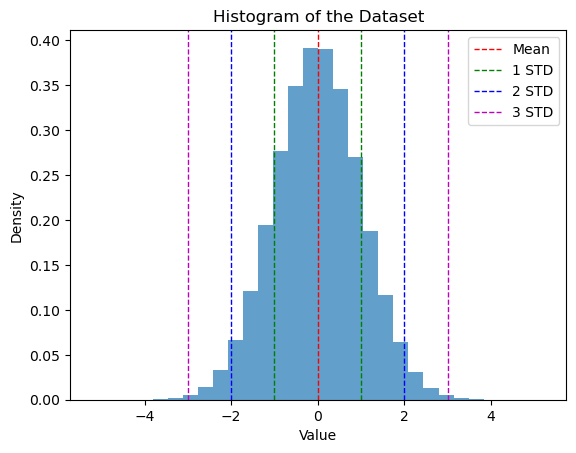

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # Set the random seed for reproducibility
data = np.random.normal(0, 1, 10000000)

mean = np.mean(data)
std = np.std(data)

plt.hist(data, bins=30, density=True, alpha=0.7)

# Plot the mean and standard deviations
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(mean - std, color='g', linestyle='dashed', linewidth=1, label='1 STD')
plt.axvline(mean + std, color='g', linestyle='dashed', linewidth=1)
plt.axvline(mean - 2*std, color='b', linestyle='dashed', linewidth=1, label='2 STD')
plt.axvline(mean + 2*std, color='b', linestyle='dashed', linewidth=1)
plt.axvline(mean - 3*std, color='m', linestyle='dashed', linewidth=1, label='3 STD')
plt.axvline(mean + 3*std, color='m', linestyle='dashed', linewidth=1)

plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of the Dataset')
plt.show()

- **Interquartile range (IQR)**: If the data is not normally distributed, you can use the same method boxplots use to determine the outliers -- all observations that lie 1.5 times the IQR (difference between the 75th and the 25th percentiles of the data) away from the median in either direction are treated as outliers. 


<img src="https://curriculum-content.s3.amazonaws.com/data-science/images/new_boxplot.png" width="600">


> If you need a refresher on IQR, refer to the lesson on _Measures of Dispersion_ in the _Importing and Statistical Analysis of Data_ section of Module 1.

Another way to confirm these values is to check the `.value_counts()` of a column.  In a continuously-valued column, it is probably rare for one specific value to overwhelm all the others.  If, for instance, you see the same numerical value showing up a statistically improbable number of times, double-check that this value is real -- placeholder values have the potential to show up many times, but it's much less likely for real-valued numbers.  


#### Categorical data

To detect placeholder values in categorical data, get the unique values in the column and see if there are any values that don't match up with your expectations.  Pandas provides a built-in method for this.  For instance, in the titanic dataset, we can check the unique values of the `Embarked` column by typing:

```python
df['Embarked'].unique()
```

This will return an array containing all the unique values in the dataset.  

Note that for categorical columns, it is much more likely to have a data dictionary to work with, since it is common to have categorical values that aren't readily understandable without a data dictionary to help us figure out what each potential category means.  

## Strategies for dealing with missing data

Detecting missing values isn't enough -- we need to deal with them in order to move forward. We have three options for dealing with missing values -- removing them from the dataset, keeping them, or replacing them with another value. 

### Remove

The easiest way to deal with missing values is to drop the offending rows and/or columns.  The downside to this is that we lose data in the process.  This is a valid strategy on very large datasets -- however, on smaller datasets, throwing away data may be unacceptable.  

The two main strategies for dealing with missing values are to drop columns or to drop rows. For this strategy, it does not matter if we are dealing with continuous or categorical data.  

#### Dropping columns

Consider the output from the titanic dataset shown previously.  The `Cabins` column contains 687 missing values. The entire dataset only contains around 900 rows of data.  In this case, it makes more sense to just remove the `Cabins`  column from the dataset entirely.  

Note that while this makes sense for the `Cabins` column, this is not a good idea for dealing with the null values contained within the `Age` column. Although the `Age` column contains 75 missing values, the vast majority of the items in this dataset contain perfectly good information for the age column.  If we dropped this column, we would be throwing out all that information just to deal with a small subset of missing values in that column.

#### Dropping rows

In the above example, dropping all rows that contain a null value would be a very bad idea, because we would 3/4 of our data. Dropping rows makes more sense when the proportion of rows with missing values is very small compared to the size of the overall dataset -- it's okay to just throw out the missing values as long as it's not too many observations. There's no hard rule for exactly how many missing values is the right amount to throw out, and will vary project by project.  Think critically, and use your best judgment.

To drop all rows containing missing values in a DataFrame, use `dataframe.dropna()`.  Note that this returns a copy of the dataframe with the rows in question dropped -- however, you can mutate the DataFrame in place by passing in `inplace=True` as a parameter to the method call. 

### Replace

We can also deal with missing values by replacing them with a common value. The downside of this method is that this can introduce noise into our dataset. 

#### Continuous data

For continuous data, the best solution is to replace the missing values with the median value for that column. The median value is a good choice because it is least likely to influence the distribution of the dataset overall. If the dataset is symmetric, then the mean and the median will be the same value. If the dataset is not symmetric, then the mean is more likely to be skewed by outlier values, so the median is a better choice.  

Pandas provides an easy way for us to replace null values. For instance, if we wanted to replace all null values in the `Fare` column with the column median, we would type:

```python
df['Fare'].fillna(df['Fare'].median())
```

#### Categorical data

With categorical data, this is harder, since we don't have summary statistics to lean on such as the median or the mean. In this case, if one categorical value is much more common than others, it is a valid strategy to replace missing values with this common value. However, make sure to examine your data first. If all the categorical values are equally common, picking one to replace all the missing values may do more harm than good by skewing the distribution and introducing some false signal into your dataset.

### Keep 

Sometimes, the knowledge that a value is missing can itself be informative for us.  If knowing that a value is missing tells you something, then it is often worth keeping the missing values using the following strategies. 

#### Categorical data

This one is the easiest -- just treat missing values as its own category. This may require replacing missing values with a string to denote this, as your model will still likely throw errors if the actual `NaN` values are not replaced. In that case, just replace the `NaN` values with the string `'NaN'`, or another string that makes it obvious that this value is `'missing'`.

#### Numerical data

Often, missing values inside a continuously-valued column will cause all sorts of havoc in your models, so leaving the `NaN`s alone isn't usually an option here.  Instead, consider using **_Coarse Classification_**, also referred to as **_Binning_**.  This allows us to convert the entire column from a numerical column to a categorical column by binning our data into categories. For instance, we could deal with the missing values in the `Age` column by creating a categorical column that separates each person into 10-year age ranges. Anybody between the ages of 0 and 10 would be a `1`, 11 to 20 would be a `2`, and so on.  

Once we have binned the data in a new column, we can throw out the numerical version of the column, and just leave the missing values as one more valid category inside our new categorical column.


## Summary

In this section, we learned:

* Strategies for detecting `NaN` values in pandas
* Strategies for detecting missing data denoted by place holder values
* How to deal with missing values by _Removing_, _Replacing_, or _Keeping_ them